# **ANÁLISE DOS MICRODADOS DO ENEM 2018**






O objetivo é realizar uma análise quantitativa sobre a dinâmica dos perfis inscritos no ENEM 2018, tendo em vista as condições socioeconômicas ou quaisquer outras características que possam ser o reflexo do cenário socioeconômico nacional.

Os dados estão no Google Drive, portanto, é necessário que seja montado. É possível fazer isso acessando o último item do menu lateral da página inicial (Arquivos) e clicando em "Montar Drive" representado por um símbolo de uma pasta com a logo do Google Drive.
Outra forma é seguindo as instruções da célula abaixo.

In [1]:
## Caso o Google Drive não estiver montado ainda, retirar os comentários das linhas de código abaixo
## (aquelas que possuem somente um '#').

## ATENÇÃO! Aparecerá um link externo seguro provido automaticamente pelo Google Colab para que seja 
## gerado o código de autenticação necessário para o acesso ao Drive.

## Linhas de código a descomentar:

from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Bibliotecas



Bibliotecas utilizadas:

- *pandas*: para carregar os dados em um dataframe.

- *numpy*: para realizar operações numéricas

- *seaborn*: para plotar gráficos estatisticos

- *matplotlib*: para plotar gráficos



- *zipfile*: para descompactar arquivos

- *string*: para manipular strings

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from zipfile import ZipFile
import string

# Coleta e Pré-processamento de Dados

Extraindo o arquivo .csv da pasta .zip contendo microdados do ENEM 2018


In [3]:
# complete original file stored on this Drive 
zipdata_path = '/content/drive/My Drive/Colab Notebooks/Dados/microdados_enem_2018.zip'

with ZipFile(zipdata_path, 'r') as zipfile:
  zipfile.extract('DADOS/MICRODADOS_ENEM_2018.csv')

Recebendo os dados do arquivo .csv. Será dividido em partes (*chunks*) visto que o arquivo é grande.

In [4]:
data_path = '/content/DADOS/MICRODADOS_ENEM_2018.csv'
chunk_enem2018 = pd.read_csv(data_path, sep=';', chunksize=1000000, encoding='latin-1')   # a codificacao do arquivo nao e a padrao UTF-8 

Pré-processando cada *chunk* antes de concatenar todos num só dataframe.


In [5]:
def preprocessing_chunk(chunk):

  columns_to_drop = ['CO_MUNICIPIO_RESIDENCIA', 'NO_MUNICIPIO_RESIDENCIA', 'SG_UF_RESIDENCIA',
                   'CO_MUNICIPIO_NASCIMENTO', 'CO_UF_NASCIMENTO', 'SG_UF_NASCIMENTO', 'NO_MUNICIPIO_NASCIMENTO',
                   'CO_ESCOLA', 'CO_MUNICIPIO_ESC', 'NO_MUNICIPIO_ESC','CO_UF_ESC', 'SG_UF_ESC',
                   'CO_MUNICIPIO_PROVA', 'NO_MUNICIPIO_PROVA', 'CO_UF_PROVA', 'SG_UF_PROVA', 'CO_PROVA_CN',
                   'TP_LINGUA', 'CO_PROVA_CH', 'CO_PROVA_LC', 'CO_PROVA_MT', 'NU_NOTA_COMP1', 'NU_NOTA_COMP2', 
                   'NU_NOTA_COMP3', 'NU_NOTA_COMP4', 'NU_NOTA_COMP5', 'TX_RESPOSTAS_CN', 'TX_RESPOSTAS_CH',
                   'TX_RESPOSTAS_LC', 'TX_RESPOSTAS_MT', 'TX_GABARITO_CN', 'TX_GABARITO_CH', 'TX_GABARITO_LC',
                   'TX_GABARITO_MT', 'TP_PRESENCA_CN', 'TP_PRESENCA_CH', 'TP_PRESENCA_LC', 'TP_PRESENCA_MT',
                   'TP_STATUS_REDACAO', 'Q026', 'Q027']  

  # excluindo os ausentes na prova
  df_presentes = chunk[chunk.TP_PRESENCA_CN==1]
  df_presentes = df_presentes[df_presentes.TP_PRESENCA_CH==1]
  df_presentes = df_presentes[df_presentes.TP_PRESENCA_LC==1]
  df_presentes = df_presentes[df_presentes.TP_PRESENCA_MT==1]
  df_presentes = df_presentes[df_presentes.TP_STATUS_REDACAO==1]
  
  # excluindo colunas desnecessarias
  df = df_presentes.drop(labels=columns_to_drop, axis=1)

  print(df.shape)
  return df

Concatenando as partes pre-processadas

In [6]:
%%time
list_enem2018 = []

for chunk in chunk_enem2018:
  chunk_preprocessed = preprocessing_chunk(chunk)
  list_enem2018.append(chunk_preprocessed)
df_enem2018 = pd.concat(list_enem2018)

(739176, 96)
(723221, 96)
(722367, 96)
(696180, 96)
(643416, 96)
(288800, 96)
CPU times: user 1min 25s, sys: 11.1 s, total: 1min 36s
Wall time: 1min 38s


In [7]:
df_enem2018.shape

(3813160, 96)

In [8]:
## change data types (to save up memory usage)    
# Economiza em torno de 1 GB RAM - quase metade
%%time
list_col_dtype = [col for col in df_enem2018.columns]

for col in df_enem2018.columns:
   if df_enem2018[col].dtypes == np.int64 and col != 'NU_INSCRICAO':
     df_enem2018[col] = df_enem2018[col].astype(np.int32)
   elif df_enem2018[col].dtypes == np.float64:
     df_enem2018[col] = df_enem2018[col].astype(np.float32)

CPU times: user 4.89 s, sys: 1.34 s, total: 6.23 s
Wall time: 6.26 s


# Exploratory Data Analysis

## Configurando coluna de notas

Criando uma coluna com a media das notas das 4 provas e redação

In [9]:
df_enem2018['NU_MEDIA_NOTAS'] = df_enem2018[['NU_NOTA_CN', 'NU_NOTA_CH', 
                                             'NU_NOTA_LC', 'NU_NOTA_MT',
                                             'NU_NOTA_REDACAO']].mean(axis=1, skipna=False)

Apagando as colunas das notas para economizar espaço no disco

In [10]:
df_enem2018 = df_enem2018.drop(labels=['NU_NOTA_CN', 'NU_NOTA_CH',
                                       'NU_NOTA_LC', 'NU_NOTA_MT',
                                       'NU_NOTA_REDACAO'], axis=1)

In [11]:
df_enem2018['NU_MEDIA_NOTAS'].isna().sum()

0

In [12]:
# Excluir caso haja alguma média NaN
# df_enem2018.dropna(subset=['NU_MEDIA_NOTAS'], inplace=True)

## Agrupando e Codificando Dados 

Indicador de pedido de atendimento especializado

In [13]:
list_especial = ['IN_BAIXA_VISAO', 'IN_CEGUEIRA', 'IN_SURDEZ', 'IN_DEFICIENCIA_AUDITIVA',
                 'IN_SURDO_CEGUEIRA', 'IN_DEFICIENCIA_FISICA', 'IN_DEFICIENCIA_MENTAL',
                 'IN_DEFICIT_ATENCAO', 'IN_DISLEXIA', 'IN_DISCALCULIA', 'IN_AUTISMO',
                 'IN_VISAO_MONOCULAR', 'IN_OUTRA_DEF']

df_enem2018['IN_ATEND_ESPECIALIZADO'] = df_enem2018.loc[:, list_especial].max(1)

Indicador de pedido de atendimento especifico

In [14]:
list_especifico = ['IN_GESTANTE', 'IN_LACTANTE', 'IN_IDOSO', 'IN_ESTUDA_CLASSE_HOSPITALAR']

df_enem2018['IN_ATEND_ESPECIFICO'] = df_enem2018.loc[:, list_especifico].max(1)

Indicador de pedidos de recursos especializados e especificos para a realizacao das provas

In [15]:
list_recurso = ['IN_BRAILLE', 'IN_AMPLIADA_24', 'IN_AMPLIADA_18', 'IN_LEDOR', 'IN_ACESSO',
                'IN_TRANSCRICAO', 'IN_LIBRAS', 'IN_LEITURA_LABIAL',
                'IN_MESA_CADEIRA_RODAS', 'IN_MESA_CADEIRA_SEPARADA', 'IN_APOIO_PERNA',
                'IN_GUIA_INTERPRETE', 'IN_COMPUTADOR', 'IN_CADEIRA_ESPECIAL',
                'IN_CADEIRA_CANHOTO', 'IN_CADEIRA_ACOLCHOADA', 'IN_PROVA_DEITADO',
                'IN_MOBILIARIO_OBESO', 'IN_LAMINA_OVERLAY', 'IN_PROTETOR_AURICULAR',
                'IN_MEDIDOR_GLICOSE', 'IN_MAQUINA_BRAILE', 'IN_SOROBAN', 'IN_MARCA_PASSO',
                'IN_SONDA', 'IN_MEDICAMENTOS', 'IN_SALA_INDIVIDUAL', 'IN_SALA_ESPECIAL',
                'IN_SALA_ACOMPANHANTE', 'IN_MOBILIARIO_ESPECIFICO', 'IN_MATERIAL_ESPECIFICO',
                'IN_NOME_SOCIAL']

# Como ja existe uma coluna 'IN_SEM_RECURSO' que indica se o inscrito
# fez ou nao um pedido de recurso especial ou especifico, basta apagar
# as outras colunas
df_enem2018.drop(labels=list_recurso, axis =1, inplace=True)

In [16]:
df_enem2018.drop(labels=list_especial, axis=1, inplace=True)
df_enem2018.drop(labels=list_especifico, axis=1, inplace=True)

In [17]:
df_enem2018.shape   # Reduziu drasticamente as dimensoes

(3813160, 45)

Vendo a proporção de dados não respondidos ou não informados

In [18]:
df_enem2018.isna().sum()

NU_INSCRICAO                    0
NU_ANO                          0
CO_UF_RESIDENCIA                0
NU_IDADE                       69
TP_SEXO                         0
TP_ESTADO_CIVIL            122591
TP_COR_RACA                     0
TP_NACIONALIDADE                0
TP_ST_CONCLUSAO                 0
TP_ANO_CONCLUIU                 0
TP_ESCOLA                       0
TP_ENSINO                 1461776
IN_TREINEIRO                    0
TP_DEPENDENCIA_ADM_ESC    2710249
TP_LOCALIZACAO_ESC        2710249
TP_SIT_FUNC_ESC           2710249
IN_SEM_RECURSO                  0
Q001                            0
Q002                            0
Q003                            0
Q004                            0
Q005                            0
Q006                            0
Q007                            0
Q008                            0
Q009                            0
Q010                            0
Q011                            0
Q012                            0
Q013          

In [19]:
print('TP_ESCOLA NR: {:.1f}%'.format(df_enem2018[df_enem2018['TP_ESCOLA']==1].shape[0]/df_enem2018.shape[0]*100))
print('TP_ENSINO NaN: {:.1f}%'.format(df_enem2018['TP_ENSINO'].isna().sum()/df_enem2018.shape[0]*100))
print('TP_DEPENDENCIA_ADM_ESC NaN: {:.1f}%'.format(df_enem2018['TP_DEPENDENCIA_ADM_ESC'].isna().sum()/df_enem2018.shape[0]*100))
print('TP_LOCALIZACAO_ESC NaN: {:.1f}%'.format(df_enem2018['TP_LOCALIZACAO_ESC'].isna().sum()/df_enem2018.shape[0]*100))
print('TP_SIT_FUNC_ESC NaN: {:.1f}%'.format(df_enem2018['TP_SIT_FUNC_ESC'].isna().sum()/df_enem2018.shape[0]*100))

TP_ESCOLA NR: 72.2%
TP_ENSINO NaN: 38.3%
TP_DEPENDENCIA_ADM_ESC NaN: 71.1%
TP_LOCALIZACAO_ESC NaN: 71.1%
TP_SIT_FUNC_ESC NaN: 71.1%


Decidiu-se considerar apenas aqueles que responderam na coluna TP_ESCOLA, assumir os dados NaN da coluna TP_ENSINO como 1 (Ensino Regular) e desconsiderar as colunas TP_DEPENDENCIA_ADM_ESC, TP_LOCALIZACAO_ESC e TP_SIT_FUNC_ESC da análise

In [20]:
df_enem2018 = df_enem2018[df_enem2018.TP_ESCOLA!=1]
df_enem2018['TP_ENSINO'].fillna(value=1, axis=0, inplace=True)

columns_to_drop = ['TP_DEPENDENCIA_ADM_ESC', 'TP_LOCALIZACAO_ESC', 'TP_SIT_FUNC_ESC']
df_enem2018.drop(labels=columns_to_drop, axis=1, inplace=True)

df_enem2018.reset_index(drop=True, inplace=True)

In [21]:
df_enem2018.TP_ENSINO = df_enem2018.TP_ENSINO.astype('int32')
df_enem2018.head()

,NU_INSCRICAO,NU_ANO,CO_UF_RESIDENCIA,NU_IDADE,TP_SEXO,TP_ESTADO_CIVIL,TP_COR_RACA,TP_NACIONALIDADE,TP_ST_CONCLUSAO,TP_ANO_CONCLUIU,TP_ESCOLA,TP_ENSINO,IN_TREINEIRO,IN_SEM_RECURSO,Q001,Q002,Q003,Q004,Q005,Q006,Q007,Q008,Q009,Q010,Q011,Q012,Q013,Q014,Q015,Q016,Q017,Q018,Q019,Q020,Q021,Q022,Q023,Q024,Q025,NU_MEDIA_NOTAS,IN_ATEND_ESPECIALIZADO,IN_ATEND_ESPECIFICO
0,180008257068,2018,23,19.0,M,0.0,3,1,2,0,2,1,0,0,D,D,C,B,7,C,A,B,C,A,A,B,A,B,A,A,A,A,B,B,A,B,A,A,A,417.160004,0,0
1,180007766857,2018,23,18.0,M,0.0,3,1,2,0,2,1,0,0,C,C,F,B,5,B,A,B,C,A,A,B,A,A,A,A,A,A,C,B,B,C,A,A,A,530.279968,0,0
2,180008895630,2018,25,18.0,F,0.0,1,1,2,0,2,1,0,0,H,E,F,B,7,B,A,B,C,A,A,B,A,A,A,A,A,A,B,A,A,D,A,A,B,541.900024,0,0
3,180008411104,2018,22,54.0,F,1.0,3,1,2,0,2,1,0,0,B,A,A,A,5,B,A,B,C,A,A,B,A,A,A,A,A,A,B,B,A,B,A,A,A,448.020020,0,0
4,180007286708,2018,35,17.0,F,0.0,1,1,2,0,2,1,0,0,D,E,C,B,3,C,A,B,C,B,B,B,B,B,A,A,A,B,B,B,A,D,B,B,B,473.720032,0,0


As idades não informadas serão preenchidas pelo inteiro mais próximo da média.

In [22]:
df_enem2018['NU_IDADE'].fillna(value=round(df_enem2018['NU_IDADE'].mean()), inplace=True)

O estado civil será preenchido com o valor mais frenquente.

In [23]:
df_enem2018['TP_ESTADO_CIVIL'].fillna(value=df_enem2018.TP_ESTADO_CIVIL.value_counts()[0], inplace=True)

Organizando as colunas dicotômicas

In [24]:
# Codificando a variavel dicotomica em 0 e 1
df_enem2018.TP_SEXO.replace(to_replace=['M', 'F'], value=[0, 1], inplace=True)
df_enem2018.TP_SEXO = df_enem2018.TP_SEXO.astype('int32')

Organizando as colunas categóricas

In [25]:
list_to_replace = list(string.ascii_uppercase[0:17])
list_value = list(range(17))

In [26]:
# Codificando as variáveis categóricas (A, B, C,...) em 1, 2, 3... 
df_enem2018.replace(to_replace=list_to_replace, value=list_value, inplace=True) # Toma tempo e memória

In [27]:
df_enem2018.head()

,NU_INSCRICAO,NU_ANO,CO_UF_RESIDENCIA,NU_IDADE,TP_SEXO,TP_ESTADO_CIVIL,TP_COR_RACA,TP_NACIONALIDADE,TP_ST_CONCLUSAO,TP_ANO_CONCLUIU,TP_ESCOLA,TP_ENSINO,IN_TREINEIRO,IN_SEM_RECURSO,Q001,Q002,Q003,Q004,Q005,Q006,Q007,Q008,Q009,Q010,Q011,Q012,Q013,Q014,Q015,Q016,Q017,Q018,Q019,Q020,Q021,Q022,Q023,Q024,Q025,NU_MEDIA_NOTAS,IN_ATEND_ESPECIALIZADO,IN_ATEND_ESPECIFICO
0,180008257068,2018,23,19.0,0,0.0,3,1,2,0,2,1,0,0,3,3,2,1,7,2,0,1,2,0,0,1,0,1,0,0,0,0,1,1,0,1,0,0,0,417.160004,0,0
1,180007766857,2018,23,18.0,0,0.0,3,1,2,0,2,1,0,0,2,2,5,1,5,1,0,1,2,0,0,1,0,0,0,0,0,0,2,1,1,2,0,0,0,530.279968,0,0
2,180008895630,2018,25,18.0,1,0.0,1,1,2,0,2,1,0,0,7,4,5,1,7,1,0,1,2,0,0,1,0,0,0,0,0,0,1,0,0,3,0,0,1,541.900024,0,0
3,180008411104,2018,22,54.0,1,1.0,3,1,2,0,2,1,0,0,1,0,0,0,5,1,0,1,2,0,0,1,0,0,0,0,0,0,1,1,0,1,0,0,0,448.020020,0,0
4,180007286708,2018,35,17.0,1,0.0,1,1,2,0,2,1,0,0,3,4,2,1,3,2,0,1,2,1,1,1,1,1,0,0,0,1,1,1,0,3,1,1,1,473.720032,0,0


In [28]:
df_enem2018.isna().sum()

NU_INSCRICAO              0
NU_ANO                    0
CO_UF_RESIDENCIA          0
NU_IDADE                  0
TP_SEXO                   0
TP_ESTADO_CIVIL           0
TP_COR_RACA               0
TP_NACIONALIDADE          0
TP_ST_CONCLUSAO           0
TP_ANO_CONCLUIU           0
TP_ESCOLA                 0
TP_ENSINO                 0
IN_TREINEIRO              0
IN_SEM_RECURSO            0
Q001                      0
Q002                      0
Q003                      0
Q004                      0
Q005                      0
Q006                      0
Q007                      0
Q008                      0
Q009                      0
Q010                      0
Q011                      0
Q012                      0
Q013                      0
Q014                      0
Q015                      0
Q016                      0
Q017                      0
Q018                      0
Q019                      0
Q020                      0
Q021                      0
Q022                

Visualização da comparação das variáveis *TP_SEXO* e *IN_ATEND_ESPECIFICO* (que apresentaram correlações maiores) com efeito na Nota Média no ENEM 2018 e da distribuição das notas entre as categorias.

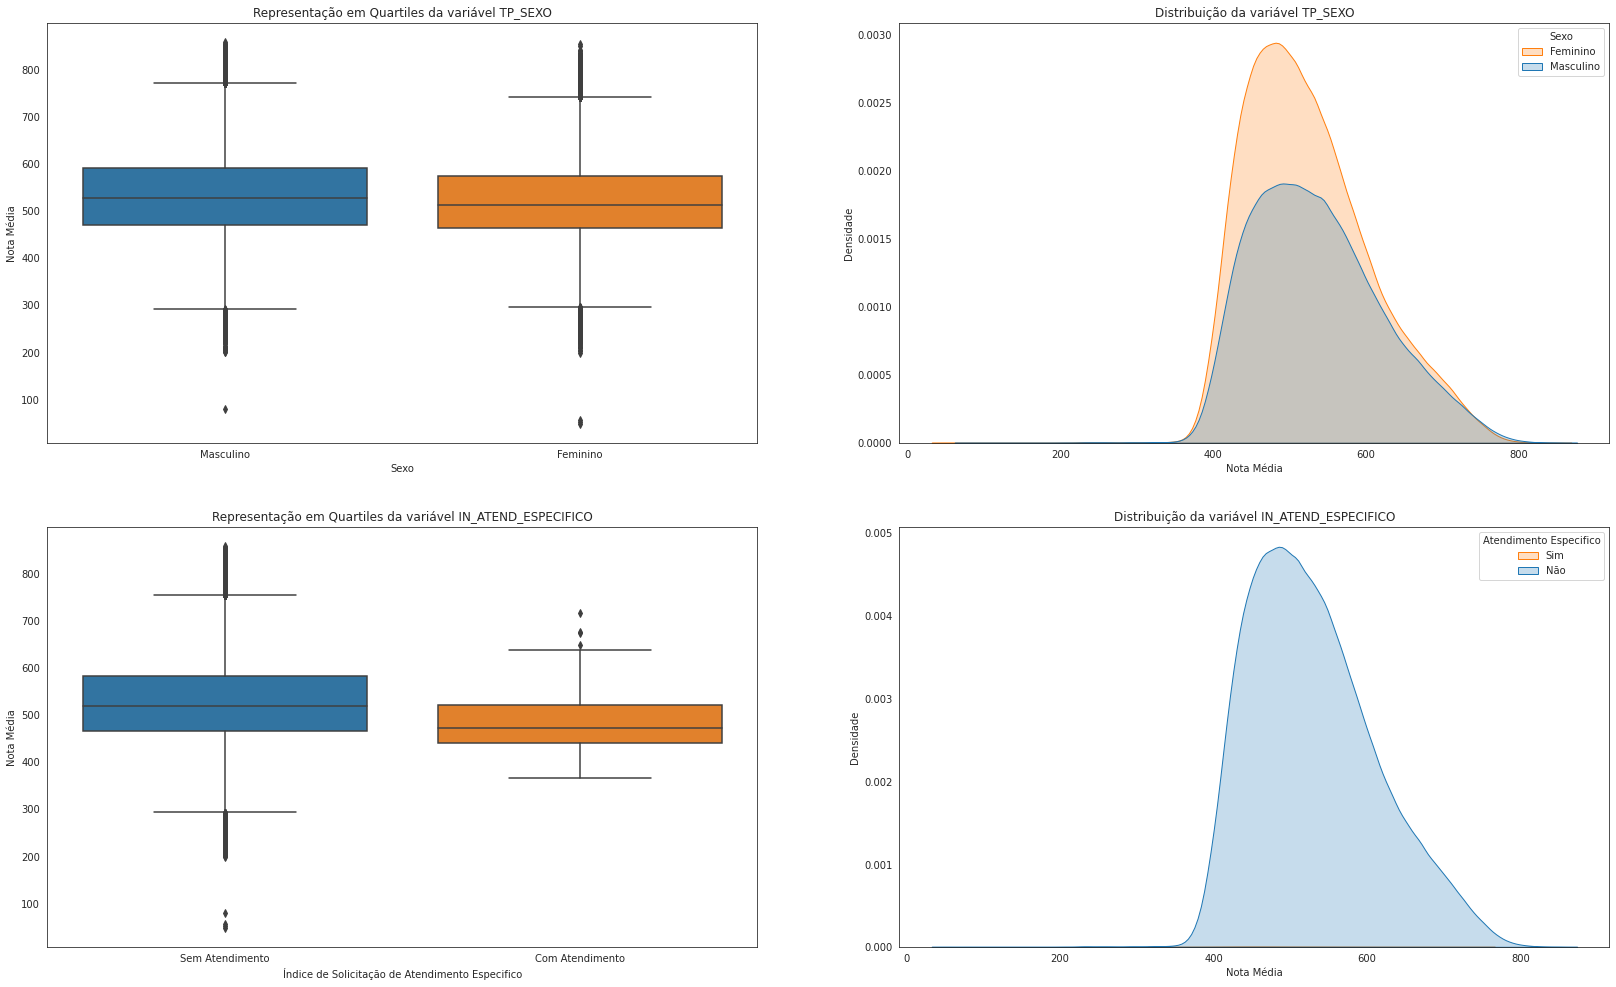

In [29]:
sns.set_style('white')
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(28, 17))

# TP_SEXO - BOXPLOT
g1 = sns.boxplot(data=df_enem2018,
                 x='TP_SEXO',
                 y='NU_MEDIA_NOTAS',
                 ax=ax[0][0])
g1.set_title('Representação em Quartiles da variável TP_SEXO')
g1.set_xticklabels(['Masculino', 'Feminino'])     # Sendo 0 - Masc e 1 - Fem
g1.set_xlabel('Sexo')
g1.set_ylabel('Nota Média')

# TP_SEXO - KDE
g2 = sns.kdeplot(data=df_enem2018,
                 x='NU_MEDIA_NOTAS',
                 hue='TP_SEXO',
                 fill=True,
                 ax=ax[0][1])
g2.set_title('Distribuição da variável TP_SEXO')
g2.legend(['Feminino', 'Masculino']).set_title('Sexo')
g2.set_xlabel('Nota Média')
g2.set_ylabel('Densidade')

# IN_ATEND_ESPECIFICO - BOXPLOT
g3 = sns.boxplot(data=df_enem2018,
                 x='IN_ATEND_ESPECIFICO',
                 y='NU_MEDIA_NOTAS',
                 ax=ax[1][0])
g3.set_title('Representação em Quartiles da variável IN_ATEND_ESPECIFICO')
g3.set_xticklabels(['Sem Atendimento', 'Com Atendimento'])     # Sendo 0 - Masc e 1 - Fem
g3.set_xlabel('Índice de Solicitação de Atendimento Especifico')
g3.set_ylabel('Nota Média')

# IN_ATEND_ESPECIFICO - KDE
g4 = sns.kdeplot(data=df_enem2018,
                 x='NU_MEDIA_NOTAS',
                 hue='IN_ATEND_ESPECIFICO',
                 fill=True,
                 ax=ax[1][1])
g4.set_title('Distribuição da variável IN_ATEND_ESPECIFICO')
g4.legend(['Sim', 'Não']).set_title('Atendimento Especifico')
g4.set_xlabel('Nota Média')
g4.set_ylabel('Densidade')


plt.show()

Plot da distribuição das notas de acordo com as idades

Text(0, 0.5, 'Nota Média')

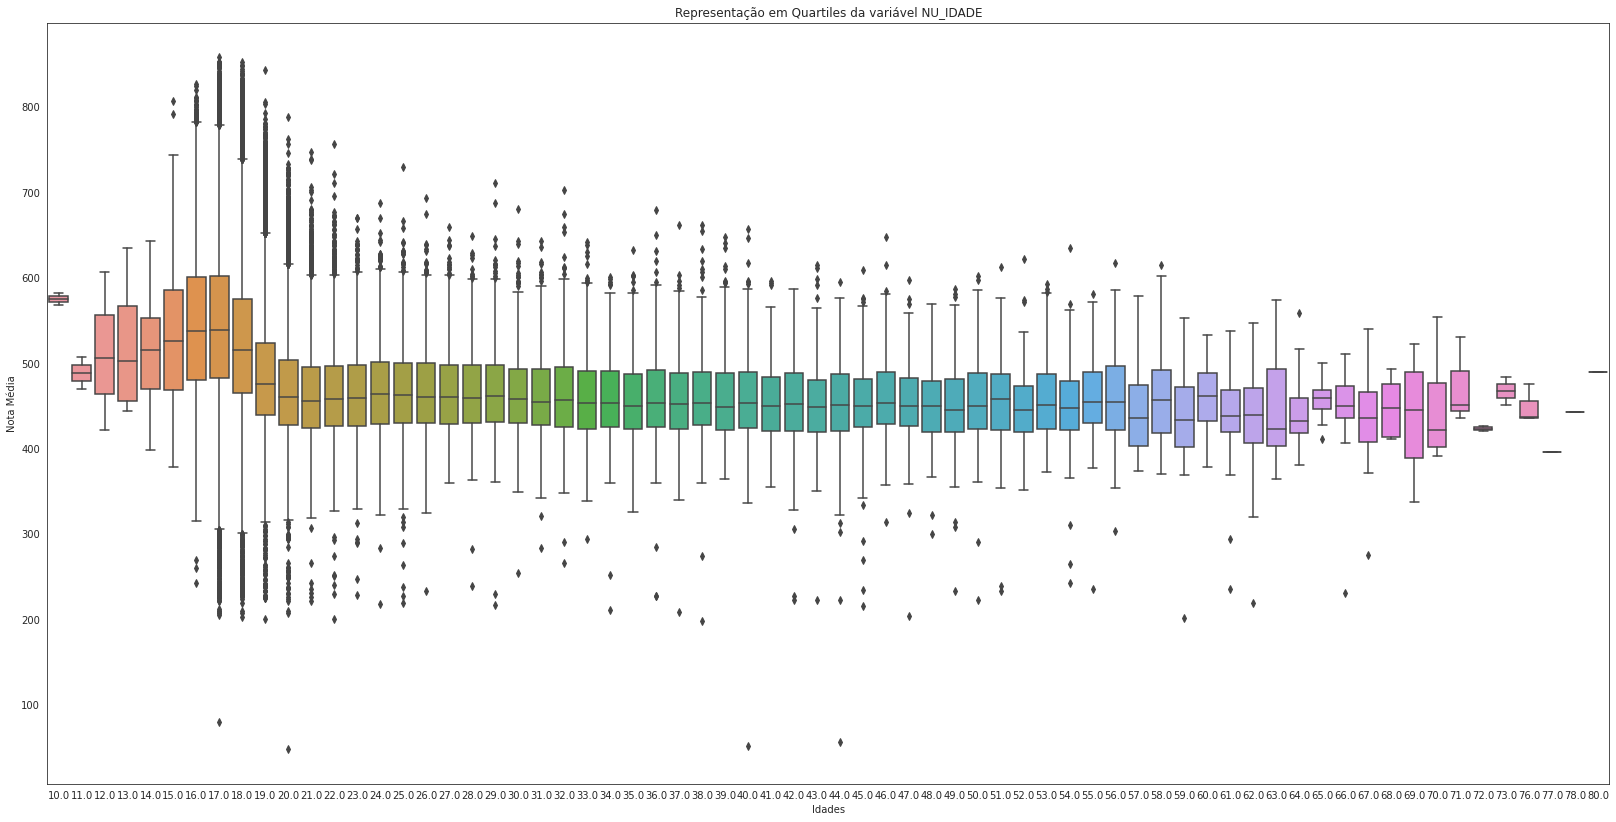

In [30]:
sns.set_style('white')
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(28, 14))

# IN_ATEND_ESPECIFICO - BOXPLOT
g3 = sns.boxplot(data=df_enem2018,
                 x='NU_IDADE',
                 y='NU_MEDIA_NOTAS')
g3.set_title('Representação em Quartiles da variável NU_IDADE')
#g3.set_xticklabels(['Sem Atendimento', 'Com Atendimento'])     # Sendo 0 - Masc e 1 - Fem
g3.set_xlabel('Idades')
g3.set_ylabel('Nota Média')

Plot da distribuição de notas por estados brasileiros

Text(0, 0.5, 'Nota Média')

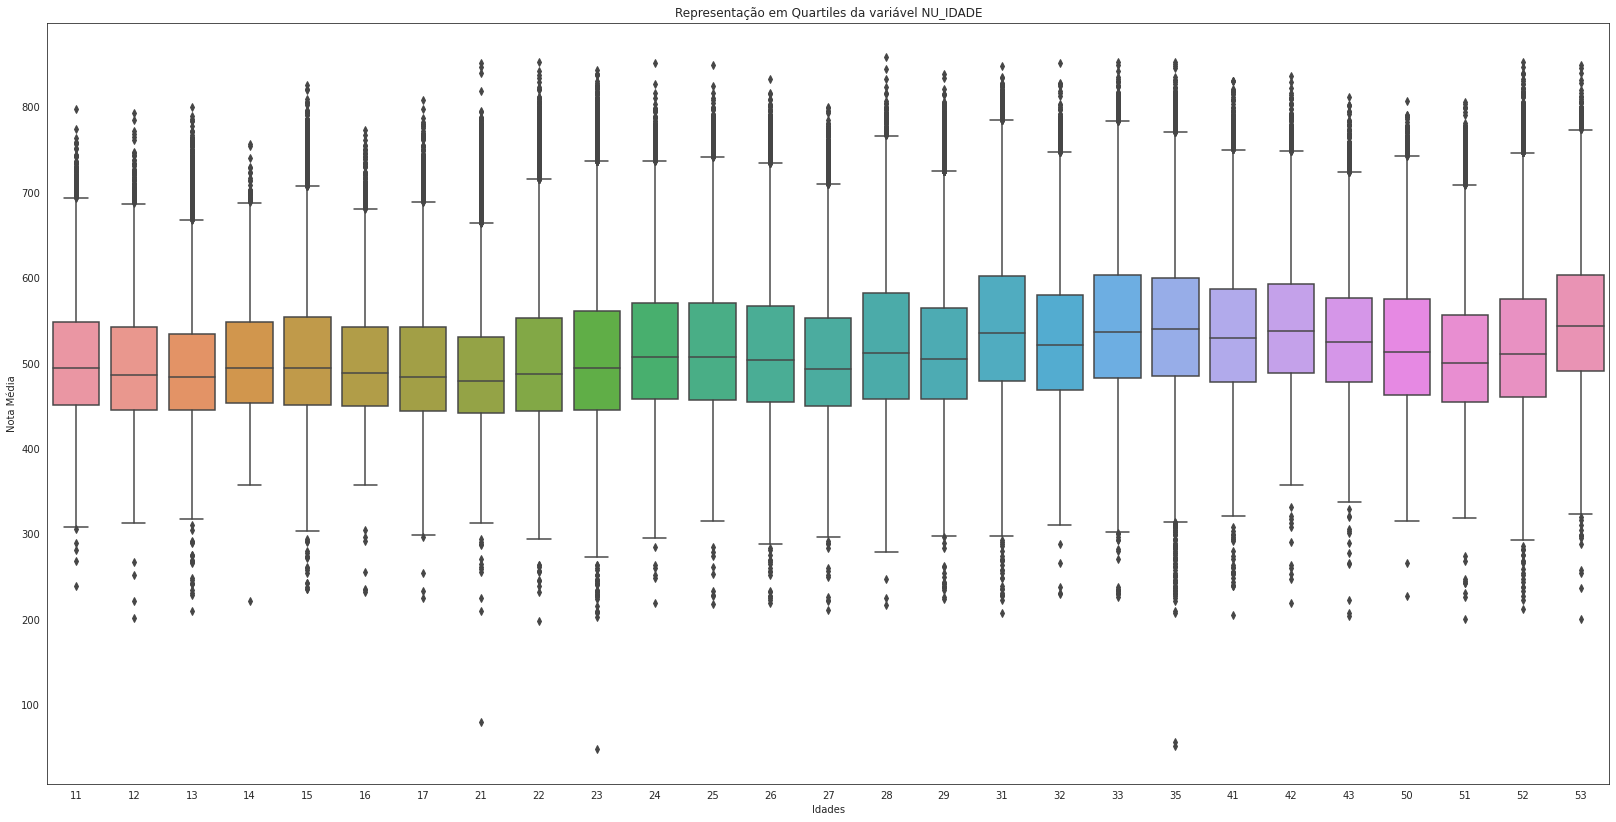

In [31]:
sns.set_style('white')
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(28, 14))

# IN_ATEND_ESPECIFICO - BOXPLOT
g3 = sns.boxplot(data=df_enem2018,
                 x='CO_UF_RESIDENCIA',
                 y='NU_MEDIA_NOTAS')
g3.set_title('Representação em Quartiles da variável NU_IDADE')
#g3.set_xticklabels(['Sem Atendimento', 'Com Atendimento'])     # Sendo 0 - Masc e 1 - Fem
g3.set_xlabel('Idades')
g3.set_ylabel('Nota Média')

# Salvando o DataFrame

Salvar o DataFrame em um arquivo .csv para a utilização de algoritmo de ML.

In [32]:
savedata_path = '/content/drive/MyDrive/Colab Notebooks/Dados/DF_ENEM_2018.csv'
with open(savedata_path, 'w') as f:
  df_enem2018.to_csv(f, index=False, encoding='latin-1')

In [33]:
df_enem2018.shape

(1060384, 42)